In [93]:
# %%writefile xxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import tools.Sample_Tools as smpl
from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [ ]:
# 跳跃方差，已实现峰度，模糊性相关的，
# 在19年 之前都非常好
# 19年之后逐步失效，21 22 完全失效

In [94]:

def get_RSJ_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######已实现波动###########################
        #已实现方差 RealizedVolatility
        r_2 = np.power(ret,2)
        rv = r_2.sum()
        
        if rv==0:
            # 无波动，停板或某些数据源的停牌
            return 0,0,0,0,0,0

        #好波
        rv_up = r_2[ret>0].sum()
        #坏波
        rv_down = r_2[ret<0].sum()

        # 有符号跳跃方差
        sj = rv_up - rv_down
        # 相对有符号的跳跃方差
        rsj = sj / rv

        n = len(ret)-1 #减一排除计算ret带来的首位nan
        # 已实现的偏度（RSK） # 与rsj共线
        # rsk = (np.power(n,0.5) * np.power(ret,3).sum()) / np.power(rv,3.0/2.0)
        # 已实现的峰度（RKT）
        rkt = (n * np.power(ret,4).sum()) / np.power(rv,2)
        ##########################################
        
        ##########################################
        volatility = ret.rolling(5).std()
        # 模糊性
        fuzziness = volatility.rolling(5).std()
        # 模糊关联度: 模糊度与成交金额
        fuzz_amount_cor = fuzziness.corr(varaints_daily.amount)
        # 模糊数量比：考察模糊性较大时，成交量是否会偏大，即计算模糊性较大时的平均分钟成交量，与日内全部时间的平均分钟成交量的比值
        volume = varaints_daily.volume
        fuzz_avg = fuzziness.mean(skipna=True)
        cond = np.where(fuzziness>fuzz_avg,1,0)
        fuzz_above_volume = (volume * cond).sum()
        fuzz_volume_ratio = fuzz_above_volume /volume[~np.isnan(fuzziness)].sum()
        # 模糊金额比：和上一个共线的，cor相差约0.0004
        amount = varaints_daily.amount
        fuzz_above_amount = (amount * cond).sum()
        fuzz_amount_ratio = fuzz_above_amount /amount[~np.isnan(fuzziness)].sum()
        # 日模糊价差,刻画的则是投资者在急于出售股票时，所付出的流动性成本
        fuzz_amo_vol_dif = fuzz_amount_ratio - fuzz_volume_ratio
        
        # print()
        return rv,rsj,rkt,fuzz_amount_cor,fuzz_volume_ratio,fuzz_amo_vol_dif
    

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['rv','rsj','rkt','fuzz_amount_cor','fuzz_volume_ratio','fuzz_amo_vol_dif'])
    
    return res_df

df_tmp = pd.DataFrame()
for code in ['000001','000002']:
    res = get_RSJ_by_code(code)
    if res is None:
        continue
    df_tmp = pd.concat([df_tmp,res],axis=0)

get_RSJ_by_code('000001')

,,rv,rsj,rkt,fuzz_amount_cor,fuzz_volume_ratio,fuzz_amo_vol_dif
datetime,,,,,,,
2016-03-01,000001,0.000192,0.231383,2.920565,0.137244,0.434289,0.000055
2016-03-02,000001,0.000175,0.529247,2.853855,-0.188649,0.465530,-0.000986
2016-03-03,000001,0.000123,0.144789,2.539490,0.054633,0.454175,0.000029
2016-03-04,000001,0.000470,0.549099,5.388142,0.071104,0.486579,0.000526
2016-03-07,000001,0.000201,-0.014717,3.521339,0.080513,0.401418,-0.000132
...,...,...,...,...,...,...,...
2020-12-25,000001,0.000234,0.045812,2.884330,0.454987,0.473105,-0.000794
2020-12-28,000001,0.000497,0.496655,5.421210,0.355730,0.479835,-0.002128
2020-12-29,000001,0.000579,0.246176,3.035142,-0.161751,0.472084,-0.000021


In [133]:
# codes = smpl.get_codes_by_market(sse='all',only_main=True,filter_st=True)
codes = smpl.get_codes_by_zs(name='沪深300', only_main=True,filter_st=True)
# codes 

worker=8
task = task_chunk_split(codes, worker)

results = parallal_task(worker, multi_test, task)


Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:19256  pid:9696


  0%|          | 0/8 [00:00<?, ?it/s]

In [132]:
def multi_test(codes):
    import numpy as np
    import pandas as pd
    import QUANTAXIS as QA
    import tools.Sample_Tools as smpl

    
    def get_RSJ_by_codex(code,st='2021-03-01',en='2022-12-31',fr=QA.FREQUENCE.FIVE_MIN):
        def calc(varaints_daily):
            close = varaints_daily.close
            ret = (close/close.shift(1) - 1)#.dropna()
            #######已实现波动###########################
            #已实现方差 RealizedVolatility
            r_2 = np.power(ret,2)
            rv = r_2.sum()

            if rv==0:
                # 无波动，停板或某些数据源的停牌
                return 0,0,0,0,0,0

            #好波
            rv_up = r_2[ret>0].sum()
            #坏波
            rv_down = r_2[ret<0].sum()

            # 有符号跳跃方差
            sj = rv_up - rv_down
            # 相对有符号的跳跃方差
            rsj = sj / rv

            n = len(ret)-1 #减一排除计算ret带来的首位nan
            # 已实现的偏度（RSK） # 与rsj共线
            # rsk = (np.power(n,0.5) * np.power(ret,3).sum()) / np.power(rv,3.0/2.0)
            # 已实现的峰度（RKT）
            rkt = (n * np.power(ret,4).sum()) / np.power(rv,2)
            ##########################################

            ##########################################
            volatility = ret.rolling(5).std()
            # 模糊性
            fuzziness = volatility.rolling(5).std()
            # 模糊关联度: 模糊度与成交金额
            fuzz_amount_cor = fuzziness.corr(varaints_daily.amount)
            # 模糊数量比：考察模糊性较大时，成交量是否会偏大，即计算模糊性较大时的平均分钟成交量，与日内全部时间的平均分钟成交量的比值
            volume = varaints_daily.volume
            fuzz_avg = fuzziness.mean(skipna=True)
            cond = np.where(fuzziness>fuzz_avg,1,0)
            fuzz_above_volume = (volume * cond).sum()
            fuzz_volume_ratio = fuzz_above_volume /volume[~np.isnan(fuzziness)].sum()
            # 模糊金额比：和上一个共线的，cor相差约0.0004
            amount = varaints_daily.amount
            fuzz_above_amount = (amount * cond).sum()
            fuzz_amount_ratio = fuzz_above_amount /amount[~np.isnan(fuzziness)].sum()
            # 日模糊价差,刻画的则是投资者在急于出售股票时，所付出的流动性成本
            fuzz_amo_vol_dif = fuzz_amount_ratio - fuzz_volume_ratio

            # print()
            return rv,rsj,rkt,fuzz_amount_cor,fuzz_volume_ratio,fuzz_amo_vol_dif


        stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
        if stock_df is None:
            return None
        stock_df = stock_df.data
        columns = ['close','volume','amount']
        var = stock_df[columns]
        var_unindex = var.reset_index()

        res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
        res_df = pd.DataFrame(res.to_list(),
                              index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                              columns=['rv','rsj','rkt','fuzz_amount_cor','fuzz_volume_ratio','fuzz_amo_vol_dif'])

        return res_df

    df_tmp = pd.DataFrame()
    for code in codes:
        res = get_RSJ_by_codex(code)
        if res is None:
            continue
        df_tmp = pd.concat([df_tmp,res],axis=0)
    return df_tmp

In [137]:
res_final_df = pd.concat(results).sort_index()
res_final_df.index.names = ['date', 'code']
# res_final_df.index=pd.MultiIndex.from_arrays([res_final_df.index.get_level_values(0).to_timestamp(),res_final_df.index.get_level_values(1)])
res_final_df

rv       rsj        rkt  fuzz_amount_cor  \
date       code                                                     
2021-03-01 000001  0.000376  0.099358   4.447509         0.171879   
           000002  0.000895  0.047708   3.722858         0.388627   
           000063  0.000235  0.285433   4.170556        -0.019733   
           000069  0.000376 -0.094590   3.194692        -0.158880   
           000100  0.000319 -0.051497   2.860278        -0.115963   
...                     ...       ...        ...              ...   
2022-12-30 603899  0.000496 -0.188000   4.076165        -0.264333   
           603986  0.000260 -0.592204  10.883792         0.185019   
           603993  0.000138 -0.309208   2.971068         0.334190   
           605117  0.001077  0.122608   7.059738         0.118297   
           605499  0.000233  0.145918   2.714283        -0.185655   

                   fuzz_volume_ratio  fuzz_amo_vol_dif  
date       code                                         
2021-03-01 000001           0.481598         -0.000310  
           000002           0.566348          0.000460  
           000063           0.459275         -0.000387  
           000069           0.474817          0.000998  
           000100           0.484958         -0.000470  
...                              ...               ...  
2022-12-30 603899           0.334447         -0.000328  
           603986           0.449954          0.000706  
           603993           0.465189         -0.000556  
           605117           0.538491          0.001195  
           605499           0.519587         -0.000206  

[111849 rows x 6 columns]

In [150]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = True
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2022'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()


ret = smpl.get_forward_return(data_,'close')
ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan

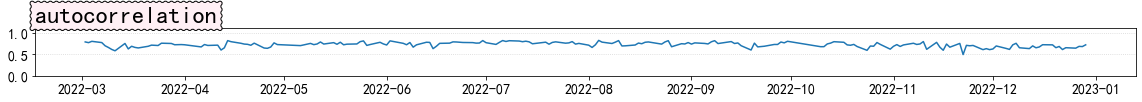

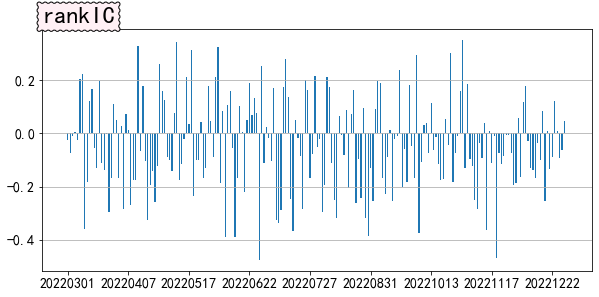

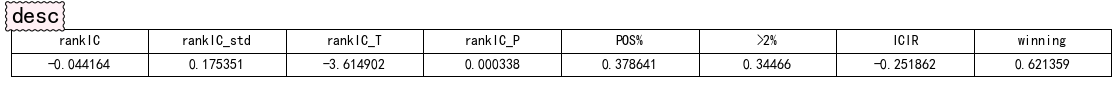

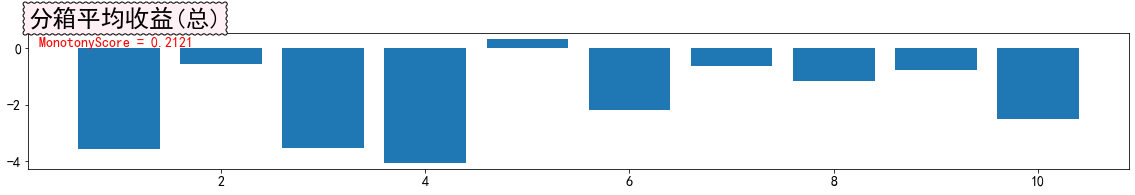

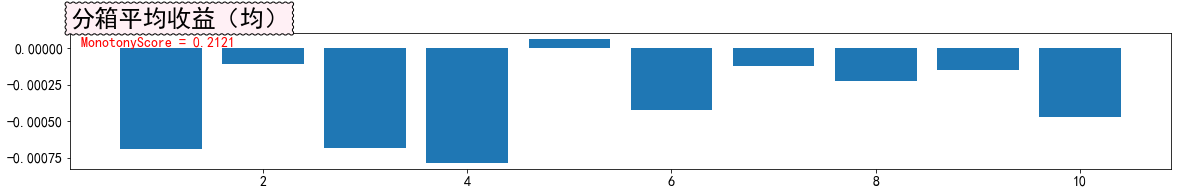

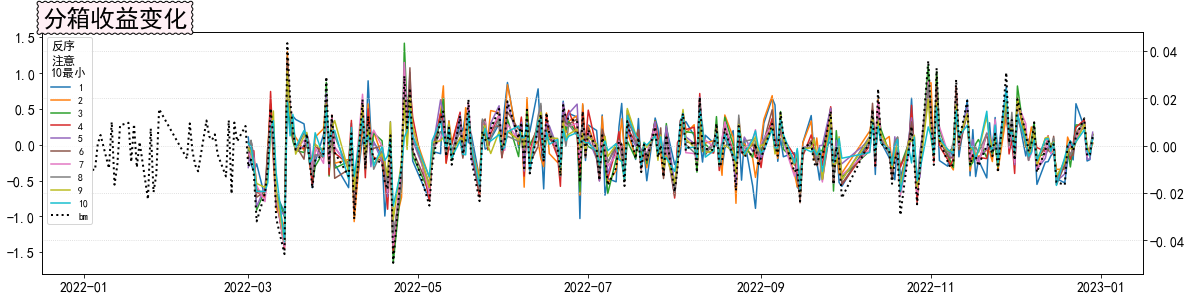

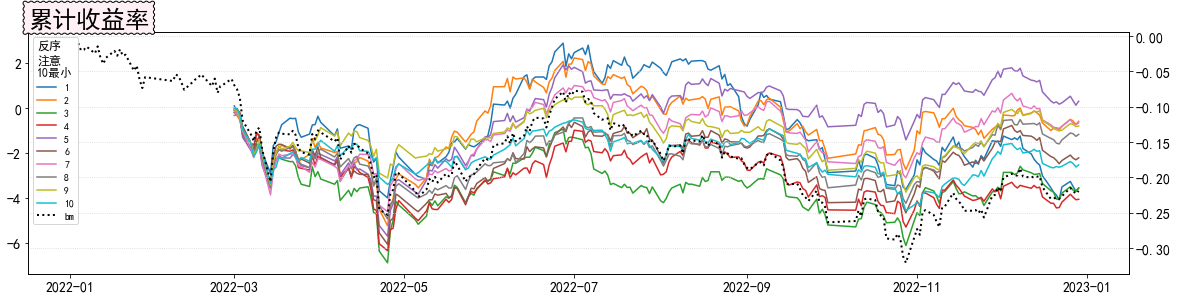

Wall time: 2.63 s


In [151]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(res_final_df['rv'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

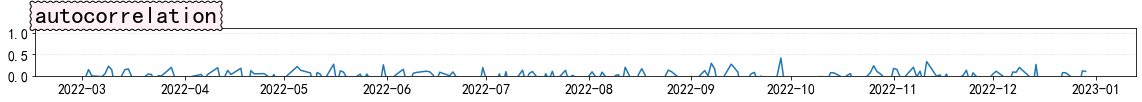

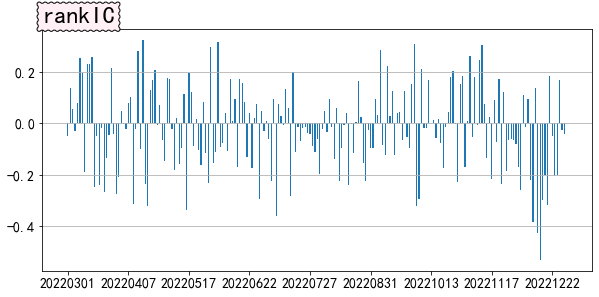

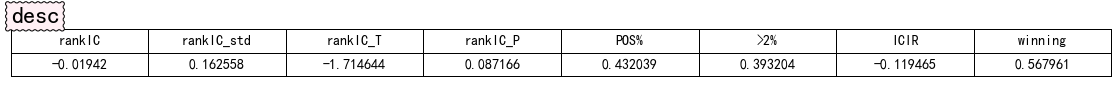

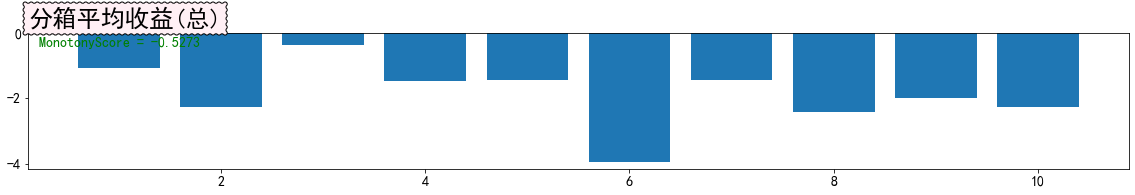

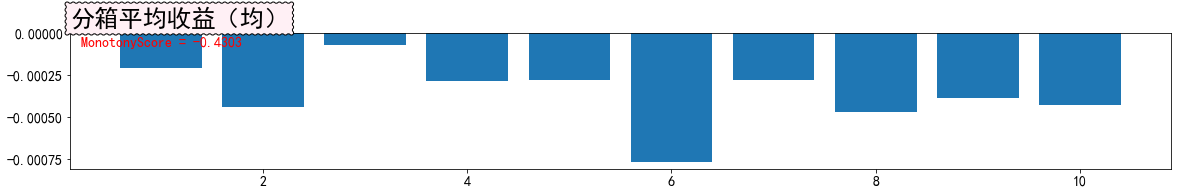

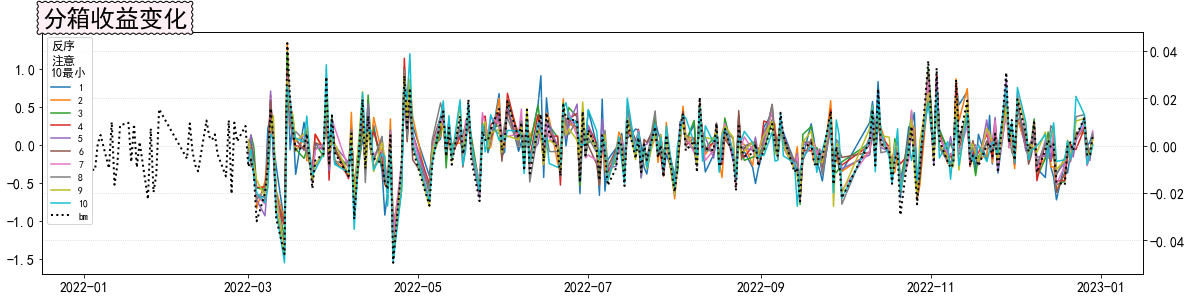

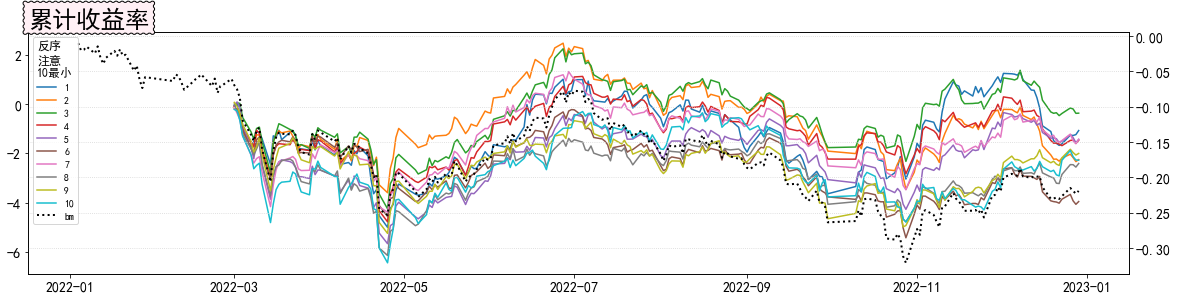

In [152]:
fa = pd.DataFrame(res_final_df['rsj'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

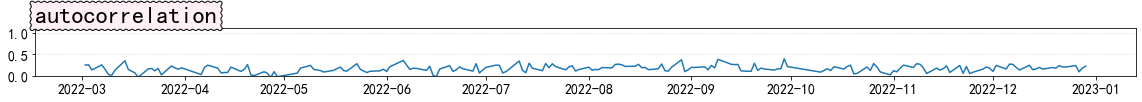

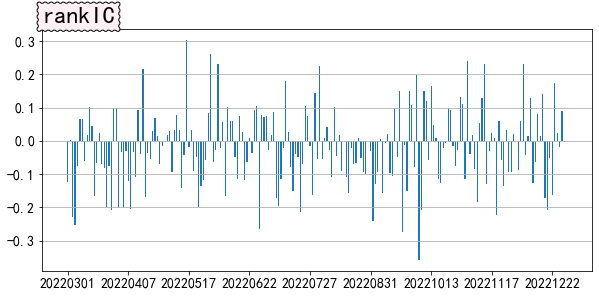

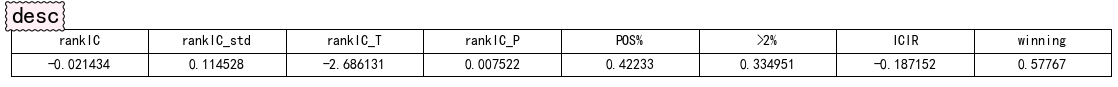

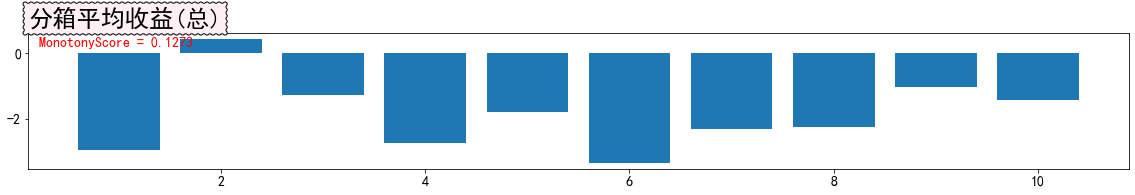

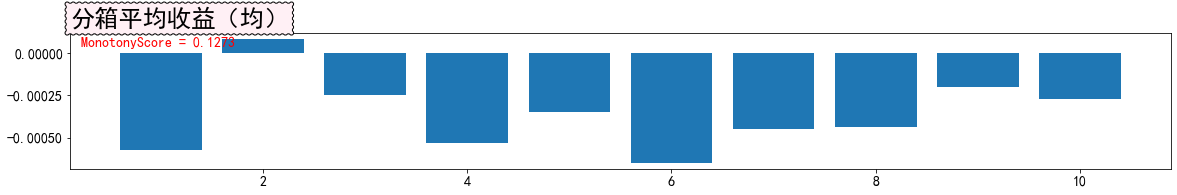

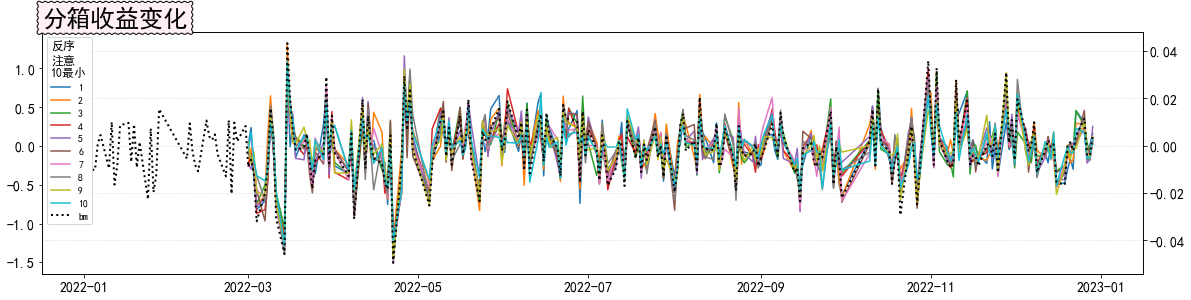

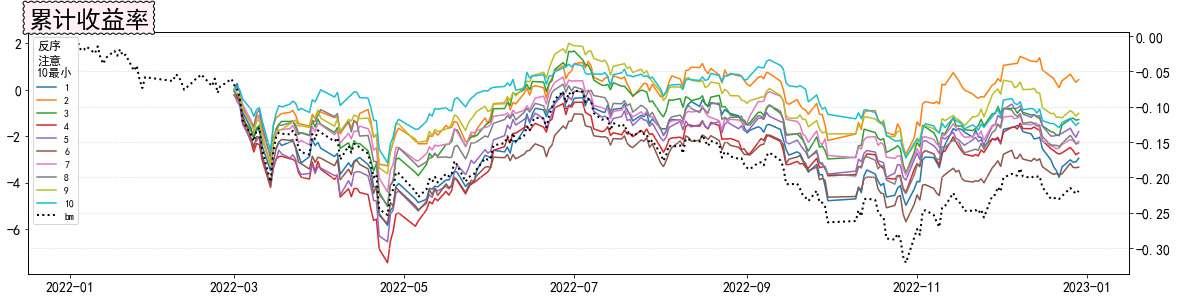

In [153]:
fa = pd.DataFrame(res_final_df['rkt'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

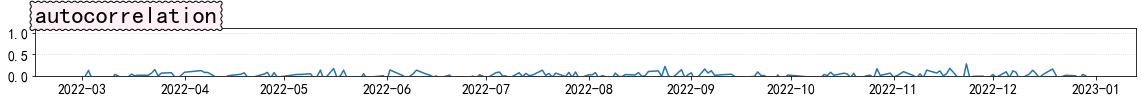

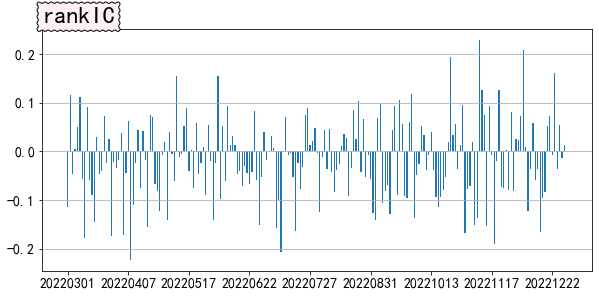

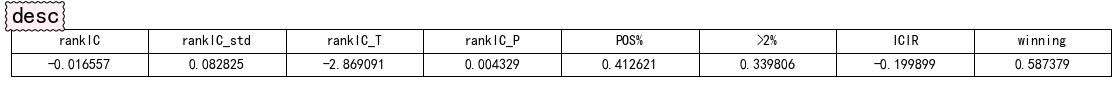

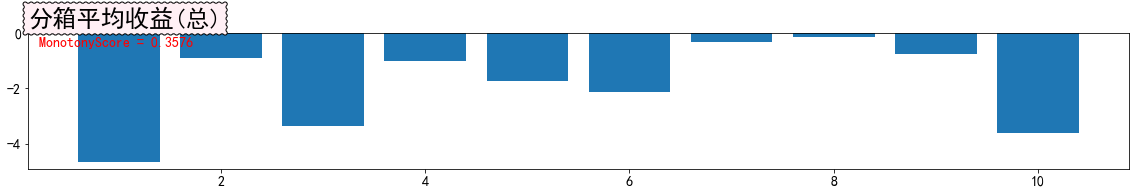

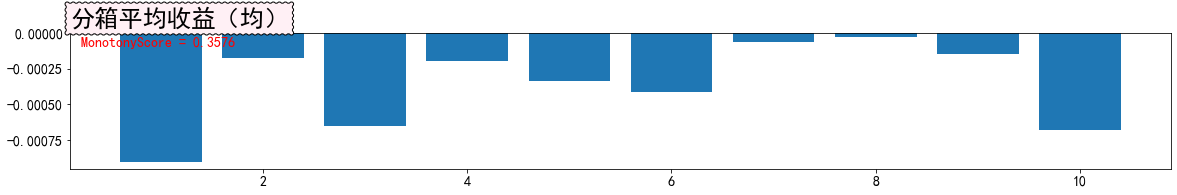

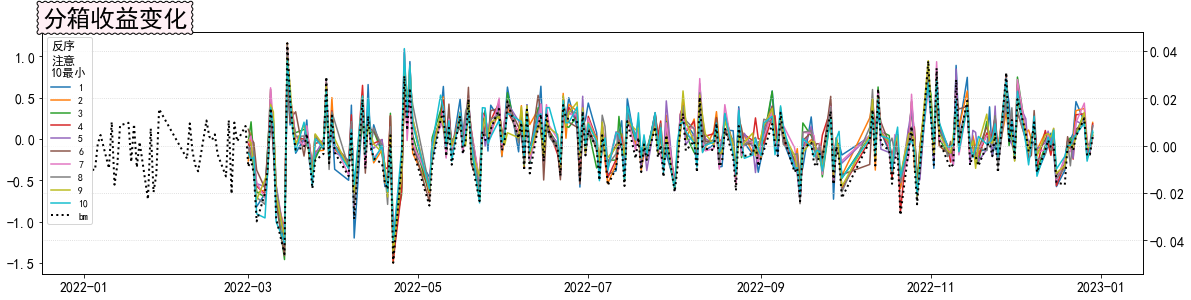

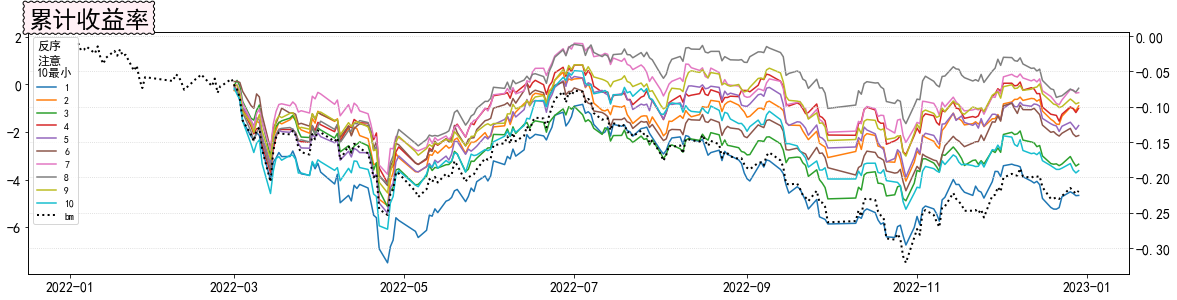

In [154]:
fa = pd.DataFrame(res_final_df['fuzz_amount_cor'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


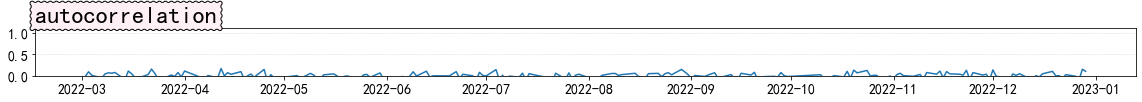

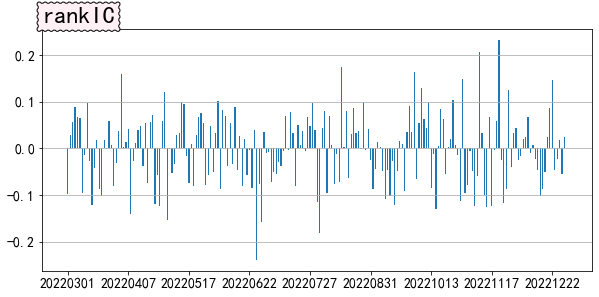

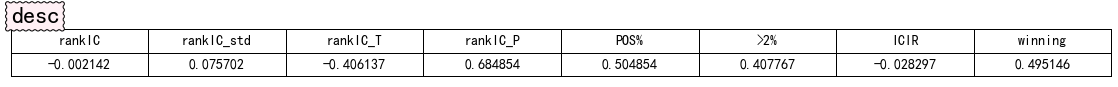

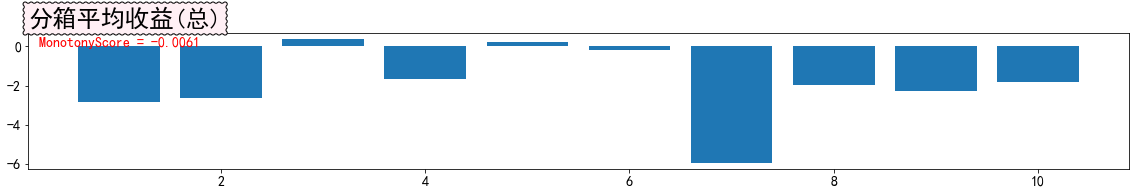

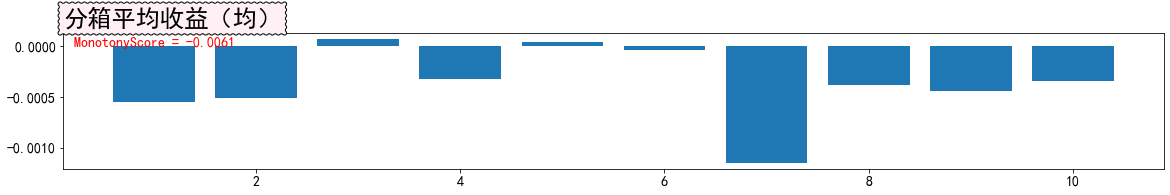

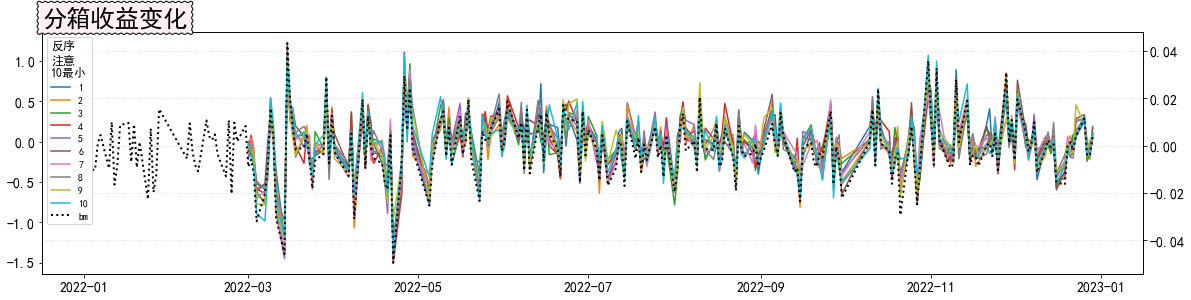

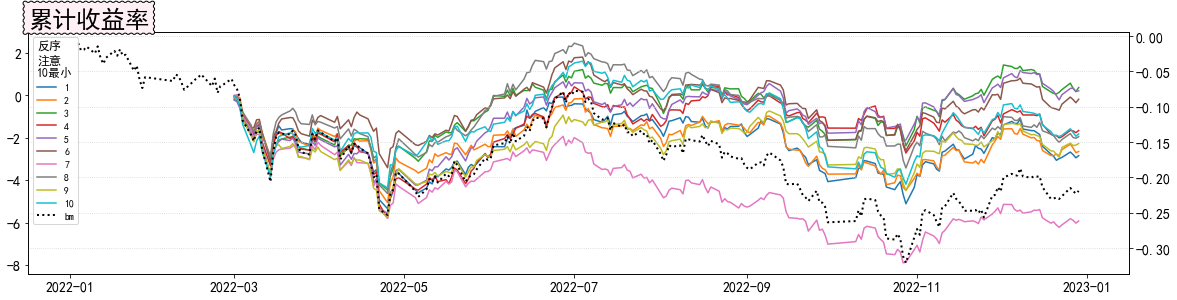

In [155]:
fa = pd.DataFrame(res_final_df['fuzz_volume_ratio'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


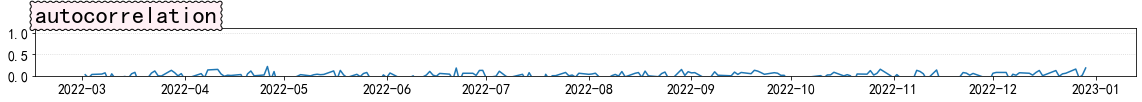

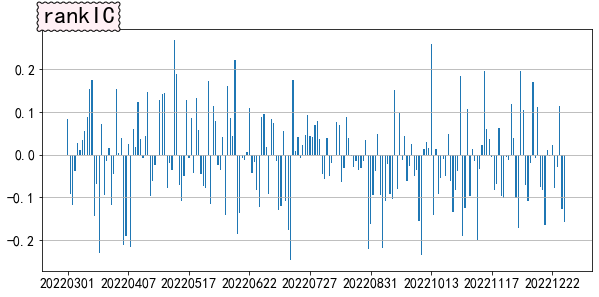

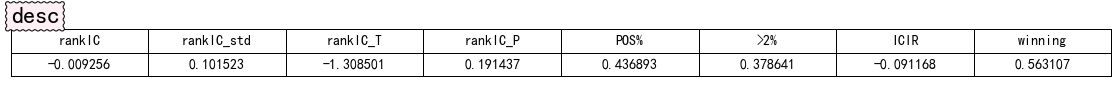

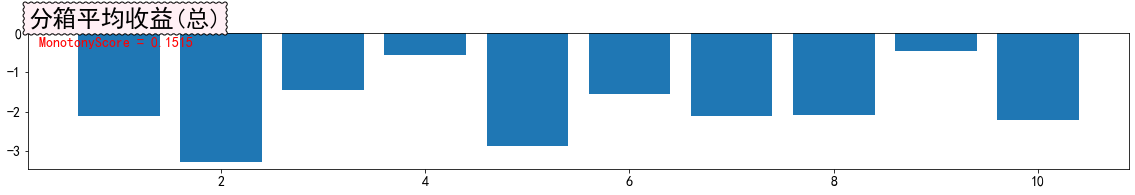

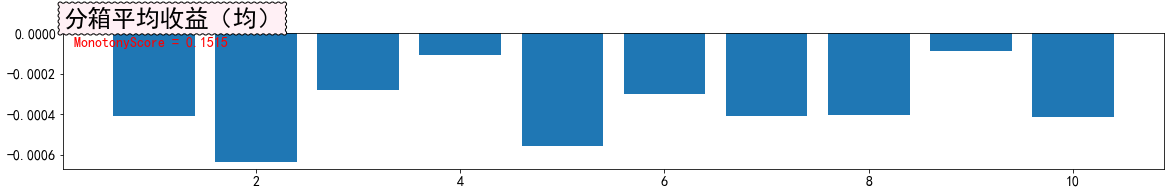

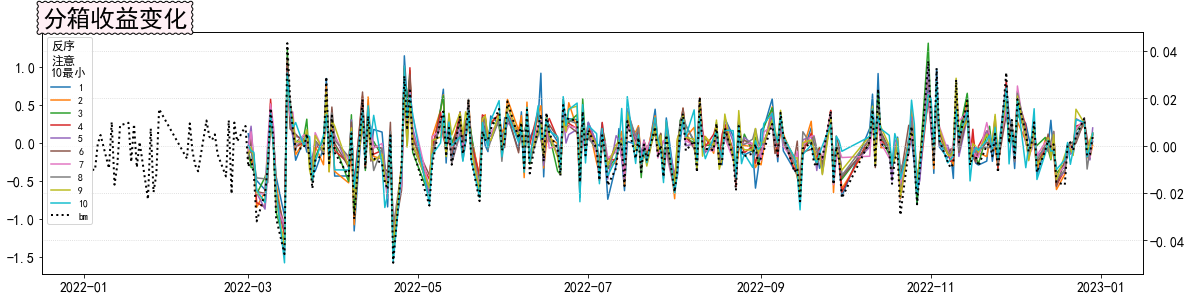

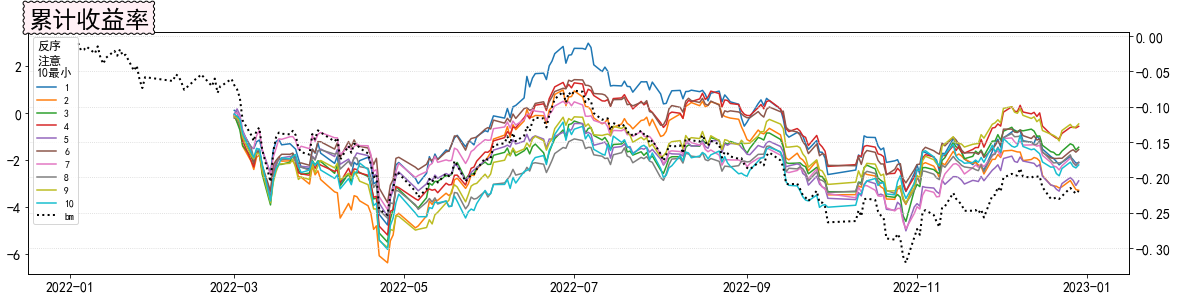

In [156]:
fa = pd.DataFrame(res_final_df['fuzz_amo_vol_dif'].loc[year1+'-03-01':year2+'-12-31']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()
